# Imports

In [1]:
# %matplotlib widget

from utility_data import *
from utility_plots import *

# Loading Data

- `train_audio/`: short recordings of individual species with labels - *supervised learning*
- `train_soundscapes/`: long recordings without labels - *unsupervised learning*
- `train.csv`: metadata for the training audio


## Dataset Interaction

In [2]:
from torchaudio.transforms import MelSpectrogram, MFCC

# DEFINE TRANSFORM
sample_rate = 32000

mel = MelSpectrogram(sample_rate=sample_rate, n_mels=32)
mfcc = MFCC(sample_rate=sample_rate, n_mfcc=32)

/usr/local/Caskroom/miniconda/base/envs/birdclef/lib/python3.13/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [3]:
from torch.utils.data import DataLoader

# INITIALIZE TRAIN_AUDIO DATASET & DATALOADER
ta_dataset = AudioDataset(metadata=True)
ta_dataloader = DataLoader(ta_dataset, batch_size=16, shuffle=True, num_workers=0)

# DEFINE TRAIN_AUDIO METADATA
ta_metadata = ta_dataset.data.iloc[:, -6:]

# INITIALIZE TRAIN_SOUNDSCAPES DATASET & DATALOADER
ts_dataset = AudioDataset(metadata_csv="", audio_dir="train_soundscapes", metadata=True)
ts_dataloader = DataLoader(ts_dataset, batch_size=16, shuffle=True, num_workers=0)

# DEFINE TRAIN_SOUNDSCAPES METADATA
ts_metadata = ts_dataset.data.iloc[:, 2:]

## Frequency of labels

In [4]:
data = ta_dataset.data

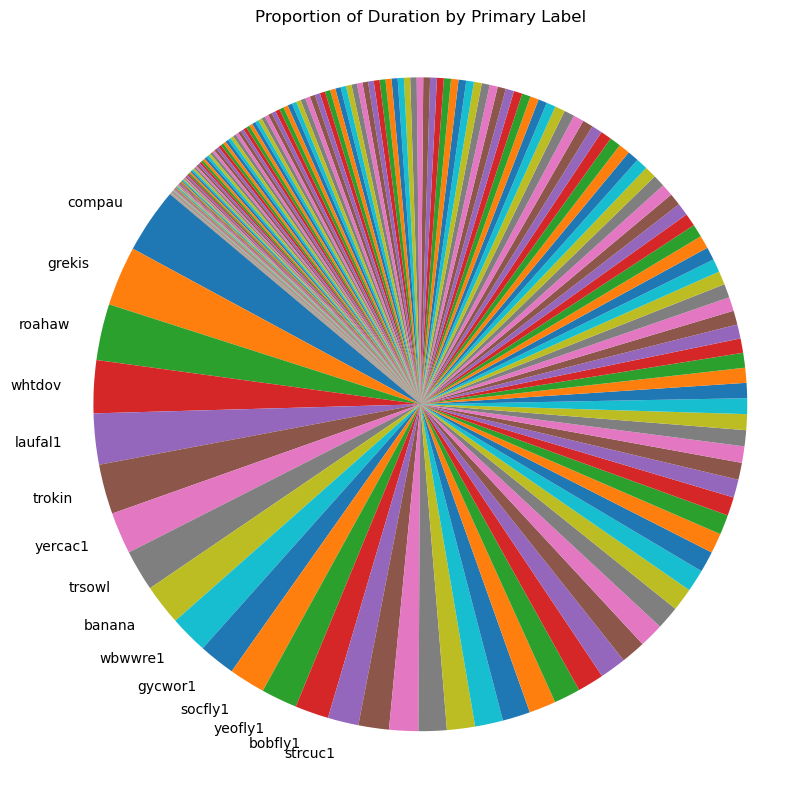

In [5]:
label_durations = data.groupby('primary_label')['duration'].sum()
label_proportions = label_durations / data['duration'].sum()

label_proportions = label_proportions.sort_values(ascending=False)

plt.figure(figsize=(8, 8))
plt.pie(
    label_proportions,
    labels=[label if i < 15 else '' for i, label in enumerate(label_proportions.index)],
    startangle=140
)
plt.title('Proportion of Duration by Primary Label')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Frequency of primary_label')

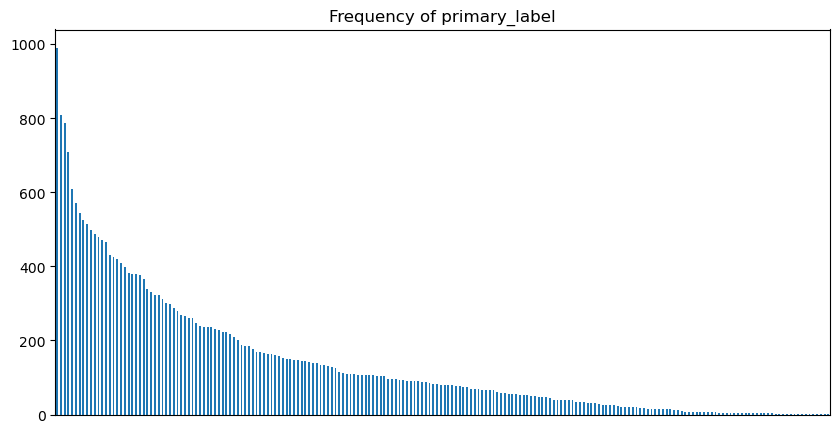

In [5]:
import matplotlib.pyplot as plt

ax = data["primary_label"].value_counts().sort_values(ascending=False).plot(figsize=(10,5), kind='bar')
ax.get_xaxis().set_visible(False)
ax.set_title("Frequency of primary_label")

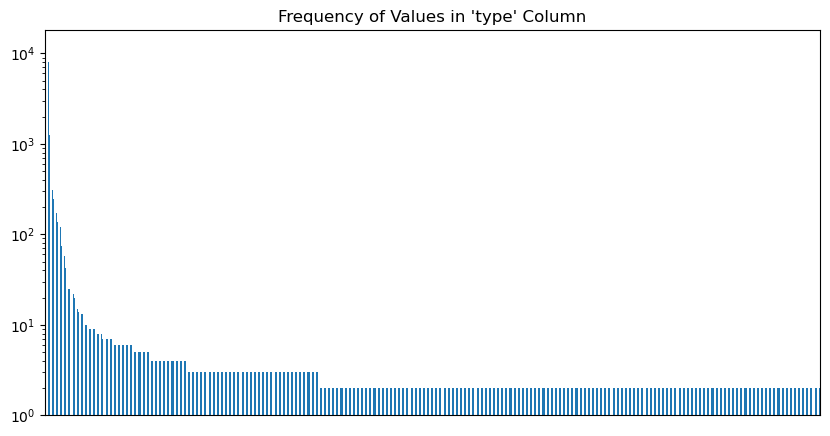

In [6]:
count_data = count_values_in_lists(data, "type")

fig, ax = plt.subplots(figsize=(10,5))
count_data.plot(kind='bar', ax=ax, log=True)
ax.get_xaxis().set_visible(False)
ax.set_title("Frequency of Values in 'type' Column")

plt.show()

In [7]:
primary_labels = data["primary_label"].unique()
summary = pd.DataFrame(primary_labels, columns=["primary_label"])

count_data = []

for col in primary_labels:
    counts_dict = dict(count_values_in_lists(data[data["primary_label"] == col], "secondary_labels"))
    count_data.append({"primary_label": col, **counts_dict})

count_df = pd.DataFrame(count_data)
summary = pd.merge(summary, count_df, on="primary_label", how="left", validate="one_to_one")

summary = summary.fillna(0)
summary = summary.rename(columns={'':'empty'})

summary['sum_values'] = summary.iloc[:, 1:].sum(axis=1)
summary = summary.sort_values(by='sum_values', ascending=False)

numeric_data = summary.iloc[:, 1:-1]
numeric_data.index = summary["primary_label"]

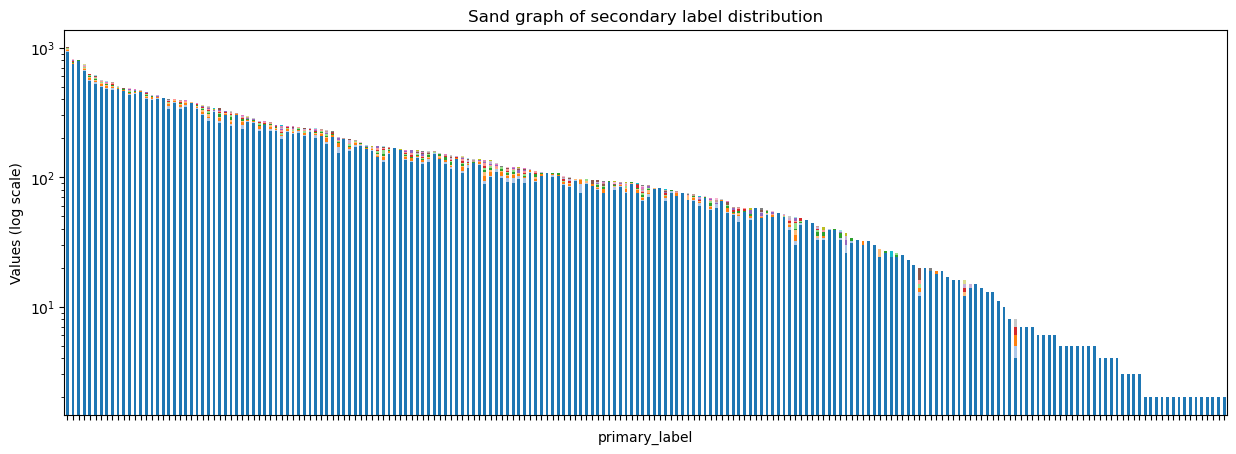

In [8]:
sand_plot(numeric_data, "Sand graph of secondary label distribution")

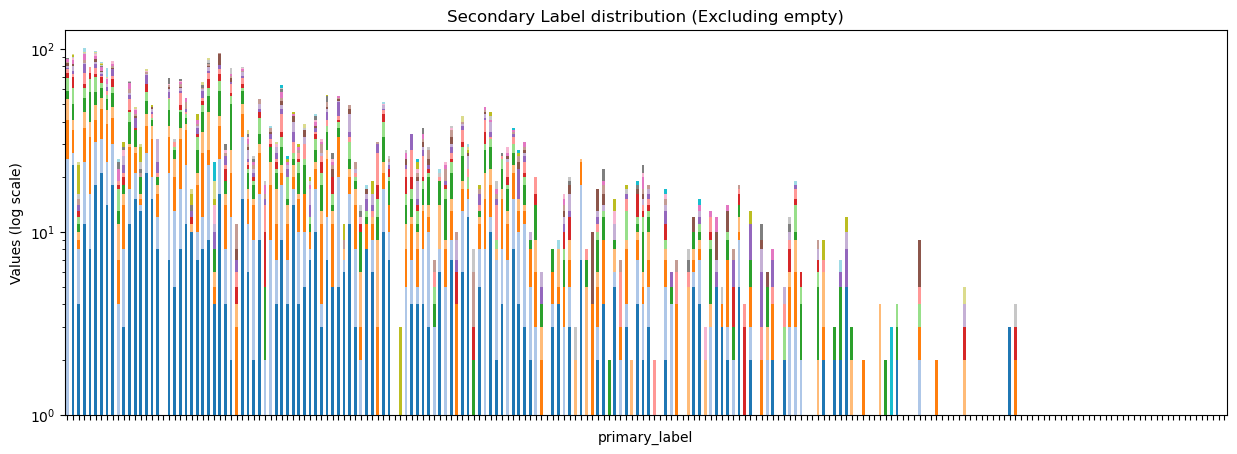

In [9]:
numeric_data_filtered = numeric_data.drop('empty', axis=1)
sand_plot(numeric_data_filtered, "Secondary Label distribution (Excluding empty)")

## Duration Value Counts

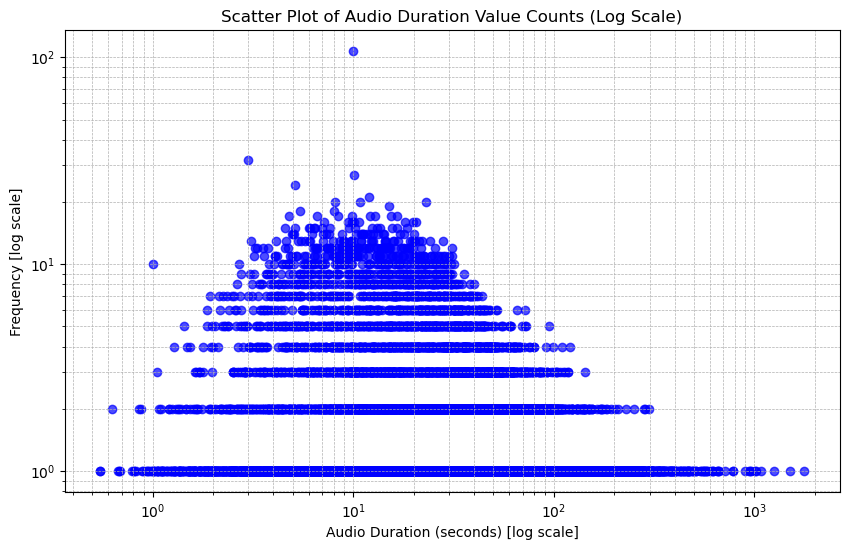

In [10]:
plot_value_counts(ta_metadata["duration"])

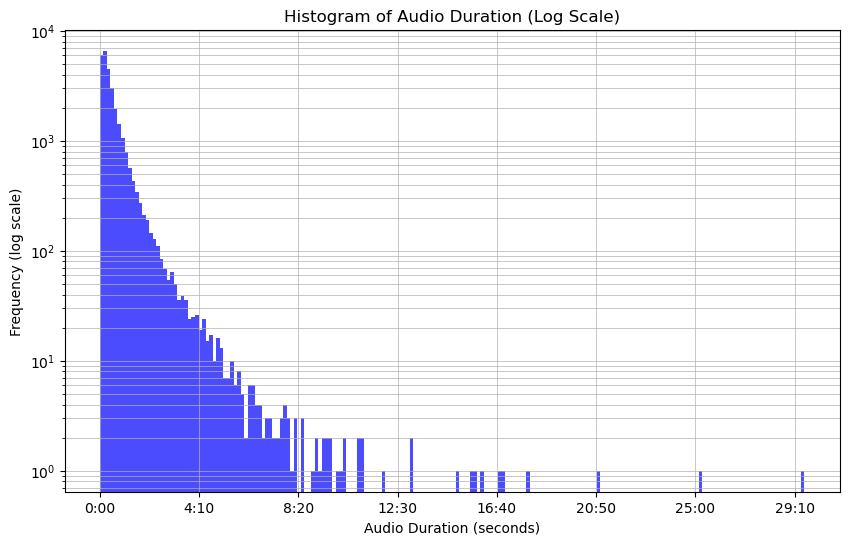

In [11]:
plot_value_histograms(ta_metadata["duration"])

In [12]:
seconds = 30

# percentage of rows with audio_duration less
perc = (ta_dataset.data["duration"] < seconds).mean() * 100
print(f'{perc:.2f}% of recordings are shorter than {seconds}')

63.83% of recordings are shorter than 30


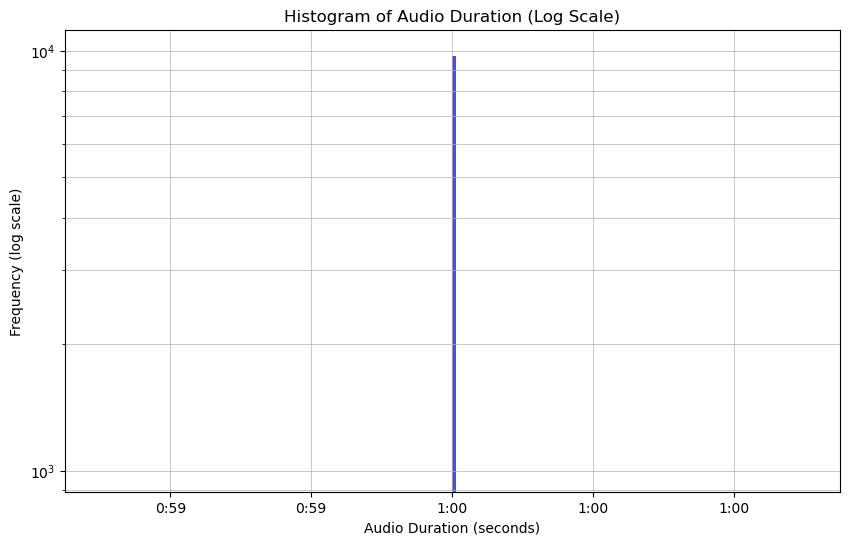

In [13]:
plot_value_histograms(ts_metadata["duration"], 200)

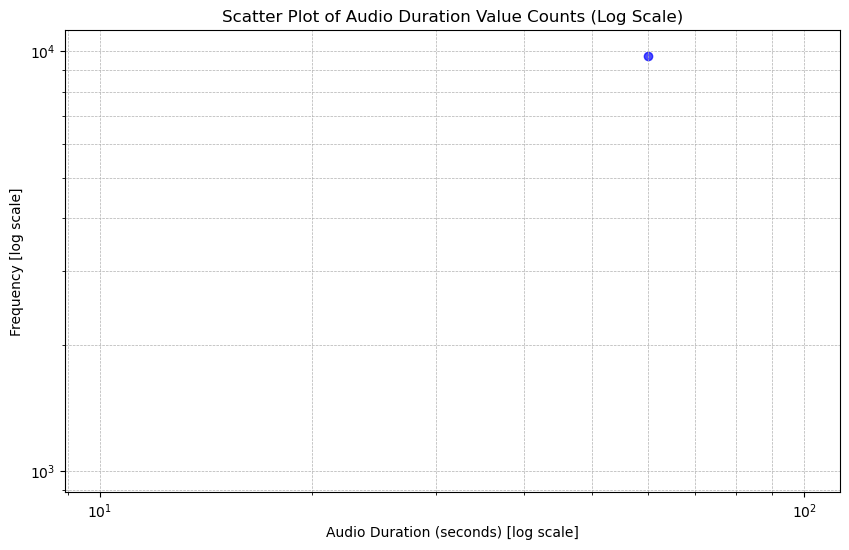

In [14]:
plot_value_counts(ts_metadata["duration"])

### Audio Sampling

In [15]:
def print_unique(data: pd.DataFrame):
    for col in data.columns:
        print(col, "has unique values:", data[col].nunique(), data[col].unique())
        
print_unique(ta_metadata[ta_metadata.columns[2:]])

sample_rate has unique values: 1 [32000]
channels has unique values: 1 [1]
bitrate has unique values: 1 [72]
file_size has unique values: 27655 [770871 755101 902788 ...  63164 197867 127801]


In [16]:
print_unique(ts_metadata[ts_metadata.columns[2:]])

channels has unique values: 1 [1]
bitrate has unique values: 1 [72]
file_size has unique values: 8729 [466860 491965 474773 ... 494012 474657 500914]


## Spectrograms

In [17]:
ta_dataset.data

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,duration,sample_rate,channels,bitrate,file_size
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,98.853375,32000,1,72,770871
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,96.537719,32000,1,72,755101
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,116.599812,32000,1,72,902788
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,105.446313,32000,1,72,823062
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,103.631469,32000,1,72,814484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,Yellow-crowned Parrot,Yennifer Alfaro,cc-by-nc 4.0,3.392000,32000,1,72,29598
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,Yellow-crowned Parrot,Evan Centanni,cc-by-nc-sa 4.0,7.659688,32000,1,72,61987
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,Yellow-crowned Parrot,Henrry,cc-by 4.0,7.666656,32000,1,72,63164
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,Yellow-crowned Parrot,Alejandro Luy,cc-by-nc 4.0,27.036750,32000,1,72,197867


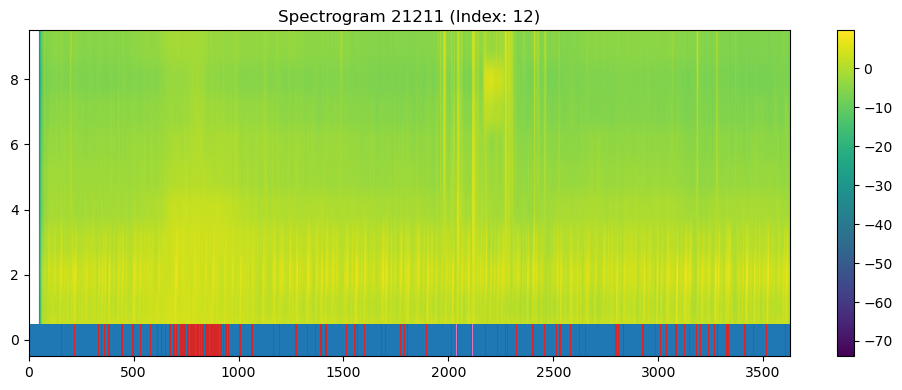

In [18]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

def run_clustering(
    data: pd.DataFrame,
    method: str = 'kmeans',
    n_clusters: int = 3,
    **kwargs
) -> pd.Series:
    """
    Run clustering on a DataFrame and return a Series of cluster labels.
    
    Parameters:
        data (pd.DataFrame): The input features.
        method (str): Clustering method - 'kmeans', 'dbscan', or 'agglomerative'.
        n_clusters (int): Number of clusters (ignored for DBSCAN).
        **kwargs: Additional parameters to pass to the clustering algorithm.
    
    Returns:
        pd.Series: Cluster labels indexed the same as the input DataFrame.
    """
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42, **kwargs)
    elif method == 'dbscan':
        model = DBSCAN(**kwargs)
    elif method == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters, **kwargs)
    else:
        raise ValueError(f"Unsupported clustering method: {method}")
    
    data["index"] = data.index.astype('float64')
    data.columns = data.columns.astype(str)

    data_scaled = StandardScaler().fit_transform(data)

    labels = model.fit_predict(data_scaled)
    return pd.Series(labels, index=data.index, name='cluster')

source = ta_dataset
index = 12

waveform, label = source.get(index)
transform = MelSpectrogram(sample_rate=32000, n_mels=10)
df = pd.DataFrame(transform(waveform).squeeze(0).detach().numpy()).T

cl = run_clustering(df, 'agglomerative', n_clusters=4)
spectrogram(source, index, transform=transform, clusters=cl)

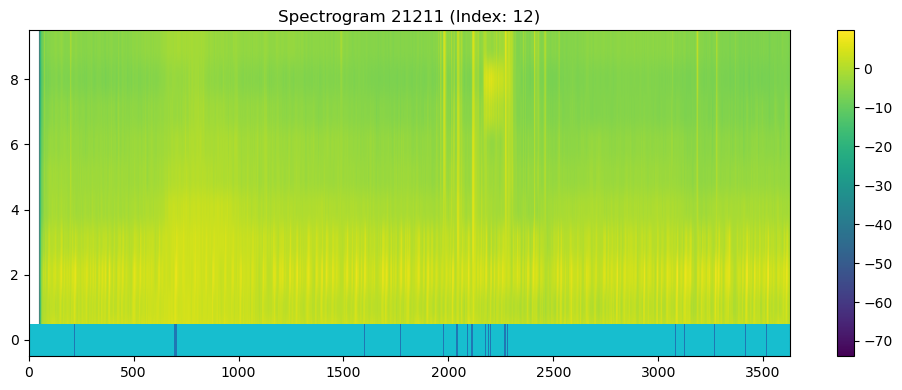

In [19]:
cl = run_clustering(df, 'dbscan', eps=3, min_samples=200)
spectrogram(source, index, transform=transform, clusters=cl)

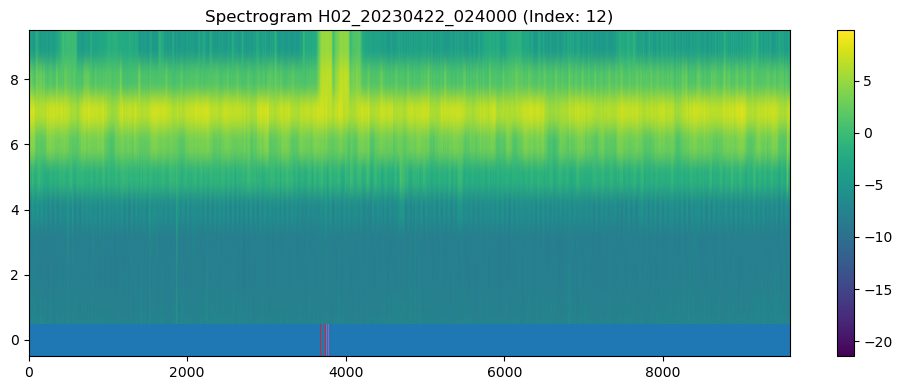

In [20]:
source = ts_dataset
index = 12

waveform_scape, label_scape = source.get(index)
df_scape = pd.DataFrame(transform(waveform_scape).squeeze(0).detach().numpy()).T

cl_scape = run_clustering(df_scape, 'dbscan', eps=2.05, min_samples=1)
spectrogram(ts_dataset, index, transform=transform, clusters=cl_scape)

## Outlier Removal

In [21]:
# remove rows where any column has a value which is an outlier by >3 STD over the column
k = 4
df_means = df.mean()
df_std_devs = df.std()
outliers = ((df - df_means).abs() > (k * df_std_devs)).any(axis=1)

# Remove rows with any outliers
df = df[~outliers]
print(outliers.sum(), "outliers are excluded")

160 outliers are excluded


## Basic Graphs

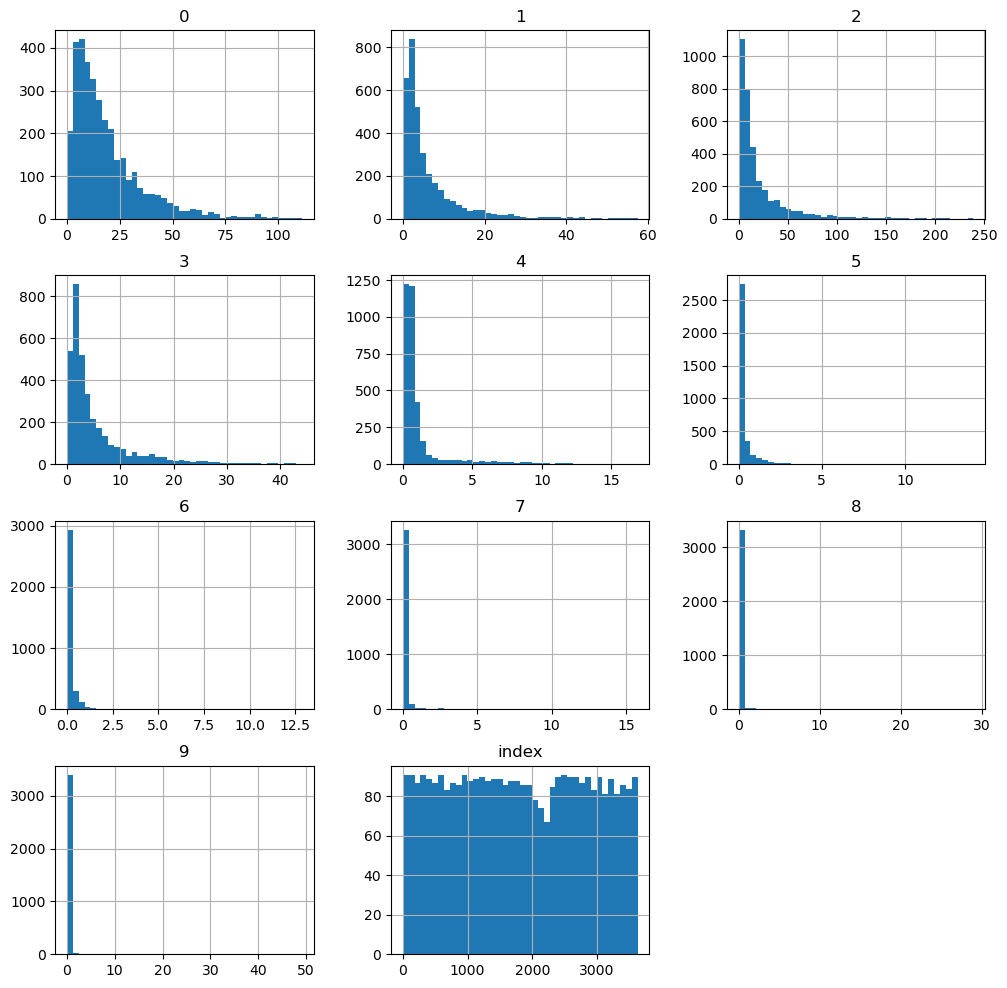

In [22]:
fig = df.hist(figsize=(12, 12), bins=40)

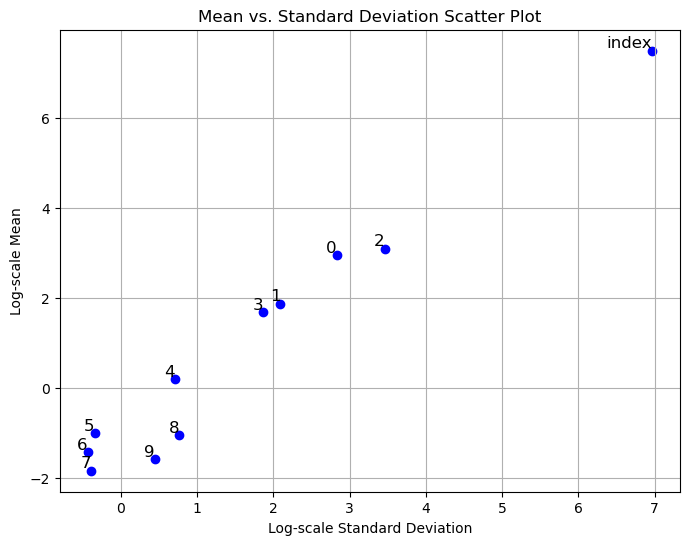

In [23]:
def plot_mean_std(df: pd.DataFrame, log_map=False):
    """Computes the mean and standard deviation for each column
    and plots the two in a scatterplot with labelled axes"""
    means = df.mean()
    std_devs = df.std()
    
    if log_map:
        epsilon = 0.005
        means = np.log(means.abs() + epsilon)
        std_devs = np.log(std_devs + epsilon)

    plt.figure(figsize=(8, 6))
    plt.scatter(std_devs, means, color='b')
    
    for col in df.columns:
        plt.text(std_devs[col], means[col], col, fontsize=12, ha='right', va='bottom')

    plt.ylabel("Log-scale Mean" if log_map else "Mean")
    plt.xlabel("Log-scale Standard Deviation" if log_map else "Standard Deviation")
    plt.title("Mean vs. Standard Deviation Scatter Plot")
    plt.grid(True)

    # Show plot
    plt.show()


plot_mean_std(df[df.columns], True)


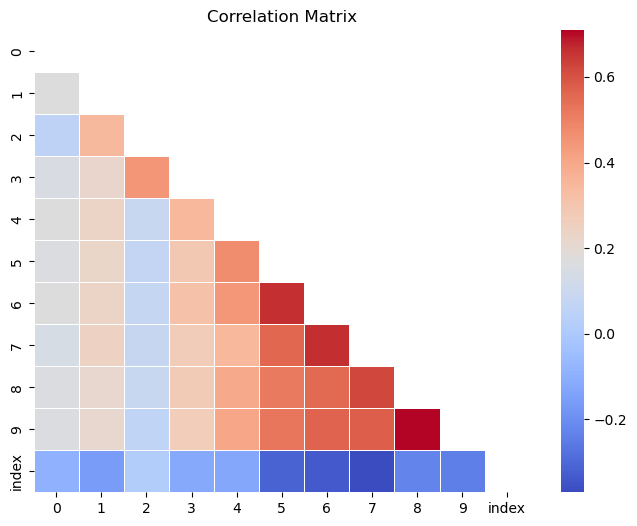

In [24]:
import seaborn as sns

corr_matrix = df.corr(method='kendall')

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, mask=mask, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## Dimensionality Reduction

In [25]:
import umap
from tqdm import tqdm

scaled_df = StandardScaler().fit_transform(df)

reducer = umap.UMAP(
    n_neighbors=200,
    min_dist=0.1,
    n_components=3,
    metric='chebyshev'
)
embedding = reducer.fit_transform(scaled_df)
embedding.shape

/usr/local/Caskroom/miniconda/base/envs/birdclef/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(3467, 3)

In [26]:
cl_filtered = cl[df.index]
print(len(cl_filtered))
cl_filtered.unique()

3467


array([ 0, -1])

Text(0.5, 1.0, 'UMAP projection of the dataset')

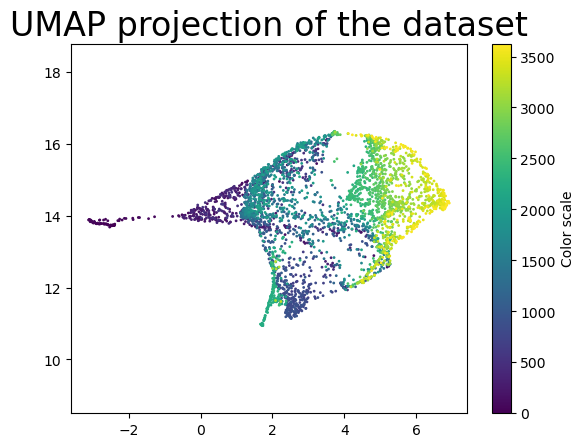

In [27]:
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1], 
    s=1, 
    c=df.index)

cbar = plt.colorbar(scatter)
cbar.set_label("Color scale")  

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24)

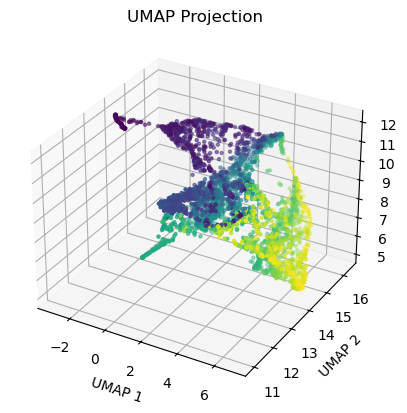

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=df.index, s=5)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP Projection')
plt.show()